# Linear Dynamic Harmonic Regression (LDHR)

__Parece que los notebooks no están muy perfecionados (o mi instalación tiene problemas). Algunos comandos fallan la primera vez que se ejecutan.__

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [1]:
clear
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [2]:
pkg load control

Cargamos los datos de la serie _"lineas aéreas"_

In [3]:
load airpas

Por comodidad vamos a generar la variable 'y' con los mismos datos (es más cómodo escribir `y` que escribir `airpas`)

In [4]:
y = airpas;

y ahora vamos a representar los datos de la serie de líneas aéreas

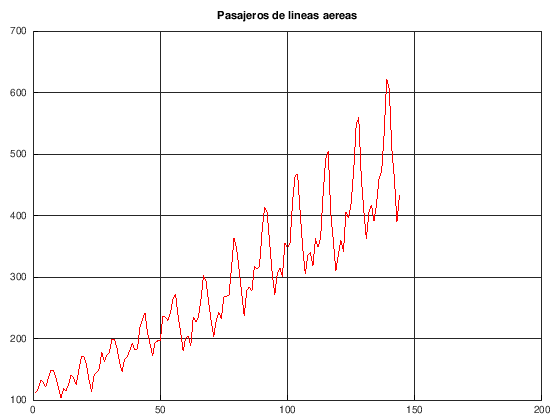

In [5]:
%plot --format png
figure(1)
grid on
hold on
title('Pasajeros de lineas aereas') % fallan los acentos
plot(y, 'r')

In [6]:
#close(1) % por si generamos la figura en una ventana y la queremos cerrar después

En `PaP` guadaremos un vector con los periodos correspondientes a la estacionalidad para datos mensuales. En esta ocasión vamos a experimentar un poco... el Profesor P.C. Young en su artículo (Young, P.C., Pedregal, D.J. and Tych, W., (1999), Dynamic harmonic regression, Journal of Forecasting, 18, 6, 369-394. [abstract](http://www.es.lancs.ac.uk/cres/papers/abstracts/young99d.html) [full text PDF](http://www.es.lancs.ac.uk/cres/papers/available/dhr.pdf)) propone incluir unos componentes cíclicos de 51.1, 25.5 y 17 meses (y lo hace mediante un sofisticado, y quizá un tanto artifical, contatenado de AR espectros). 

Aquí lo vamos a simplificar sencillamente añadiendo un componente de periodo 24 (es decir, aceptando que quizá hay un ciclo bianual). De este modo, las oscilaciones de periodo 48 o más quedarán en la tendencia y (si el modelo funciona) obtendremos un ciclo de 24 meses; además del componente estacional habitual.

In [7]:
PaP=[Inf, 24, 12./(1:6)]

PaP =

       Inf   24.0000   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000



Además vamos a emplear el modelo por defecto (IRW para la tendencia y RW para el resto de componentes). 

Si la matriz TVPaP no tiene columnas suficientes, `autodhr` replica la última columna hasta completar una matriz con columnas suficientse para todos los componentes DHR indicados en `PaP`.

In [8]:
TVPaP=[1 1 ;1 0]

TVPaP =

   1   1
   1   0



Por último, este modelo está un poco forzado, así que por defecto `autodhr` no lo identificaría de manera automática, así que añadiendo el parámetro `1` tras el argumento `TVPaP` indicamos que fuerze la estimación de dicho modelo.

In [9]:
[VAR,P,TVP,oar]=autodhr(y,12,[],[],PaP,TVPaP,1) 

VAR =

 Columns 1 through 6:

   21.475232    0.127869    1.365424   11.936893    1.557038    0.396157

 Columns 7 through 9:

    0.204077    0.195526    0.060300

P =

       Inf   24.0000   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1   1
   1   0   0   0   0   0   0   0

oar =  36


Podemos calcular los ratios de varianzas (NVR) del siguiente modo:

In [10]:
NVR=VAR(2:end)./VAR(1)

NVR =

 Columns 1 through 6:

   0.0059543   0.0635814   0.5558446   0.0725039   0.0184472   0.0095029

 Columns 7 and 8:

   0.0091047   0.0028079



Vamos a filtrar los componentes con el modelo que hemos forzado a estimar a `autodhr`. Usaré es suvizado de intervalo fijo `filt=2`

In [11]:
filt=2;
[trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,filt,0);

Visualicemos los componentes

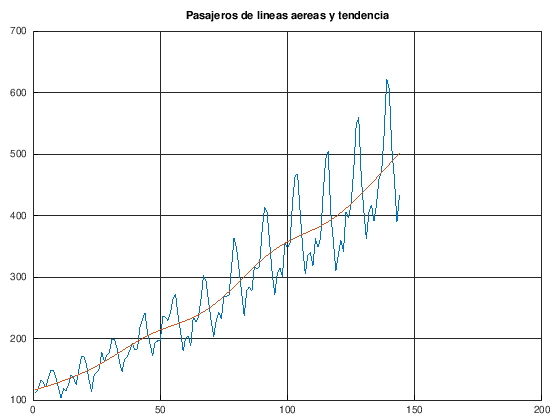

In [12]:
#figure(1)
grid on
hold on
title('Pasajeros de lineas aereas y tendencia')
plot([y,trend(:,1)])

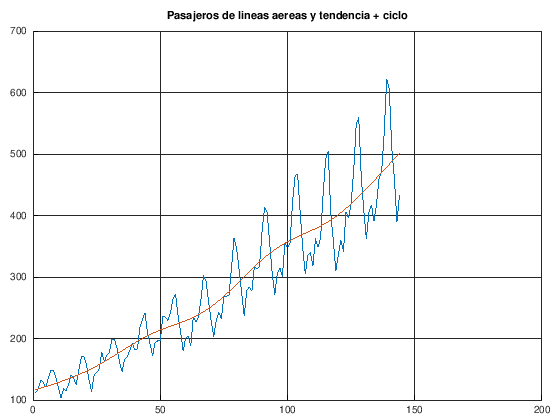

In [13]:
grid on
hold on
title('Pasajeros de lineas aereas y tendencia + ciclo')
plot([y,trend(:,1)])

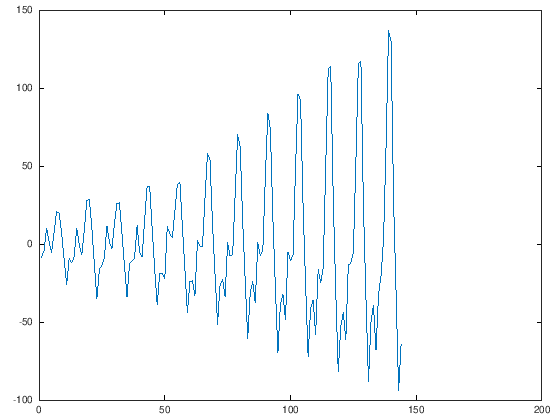

In [14]:
plot([season(:,1)])

no hemos indicado componente para un ciclo (frecuencia intermedia entre la tendencia (0) y la frecuencia del primer armónico estacional)

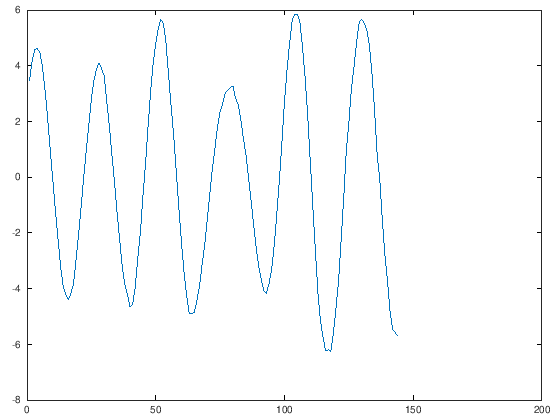

In [15]:
plot(cycle) # de periodo de arrededor de 24 meses

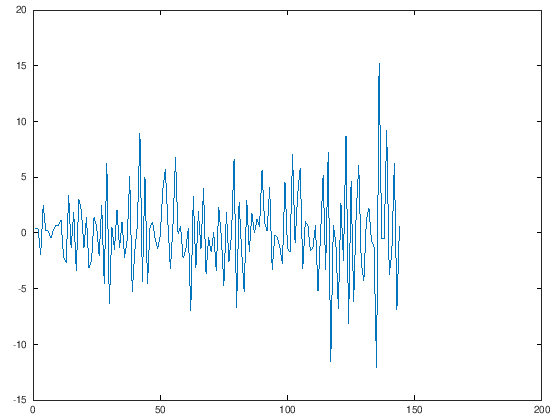

In [16]:
plot(irreg)

Pintemos la serie desestacionalizada `(trend + cycle + irreg`)

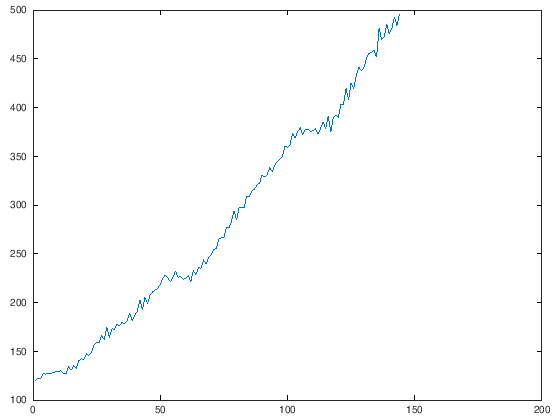

In [17]:
APsa = trend(:,1)+cycle+irreg;
plot(APsa)

Veamos la primera diferencia de la tendencia estimada (usted debería comparar este gráfico con el último gráfico del [notebook](https://hub.gke2.mybinder.org/user/mbujosab-practicasldhr-5ttb8w35/notebooks/LDHRserieAP.ipynb) que no fuerza la existencia de un ciclo para la serie de líneas aéreas):

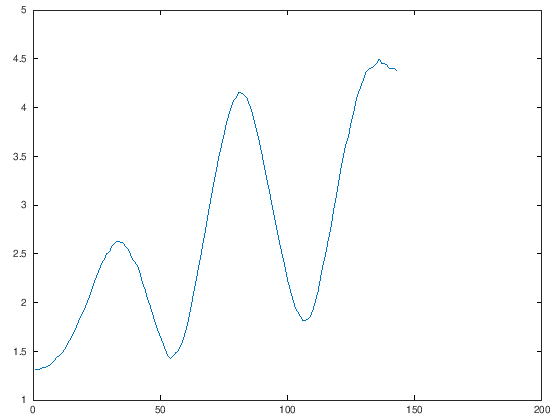

In [18]:
dtrend=diff(trend(:,1)); # diferencia del la tendencia sin el ciclo de alrededor de 24 meses
plot(dtrend)

Todo parece haber funcionado correctamente, pero esto es un tanto "experimental" y es posible que si fuerza el comportamiento de `autodhr`obtenga unos resultados demasiado artificiales, o sencillamente que el método de estimación falle.